### Image processing

In [10]:
import imageio
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [11]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    #reading image
    path=str(path).strip('b').strip("'")
    image=imageio.imread(path)
    if np.sum(np.isnan(image))>0:
        #print(str(np.sum(np.isnan(image)))+"nans found")
        #taking the mean of the image, per channel
        mean=np.nanmean(image,axis=(0,1))
        #replacing NaN with per channel mean
        replacement=np.isnan(image)*mean
        image[np.isnan(image)]=replacement[np.isnan(image)]  
        #print(str(np.sum(np.isnan(image)))+"nans found")
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
        image=image/255
    return image

In [13]:
image_files = [f for f in os.listdir("../GEE_Images")]
image_files=image_files[:5000]
len(image_files)

5000

In [68]:
""" run when mp10.txt not present
image_info=[]
for image in image_files:
    name,_=os.path.splitext(image)
    image_info.append(['_'.join(name.split(' ')[0].split('_')[:-1]),name.split(' ')[0].split('_')[-1]])
df=pd.read_csv('processed_data.csv')
mp10=[]
for info in image_info:
    mp10.append(df[(df['station']==info[0]) & (df['Date']==info[1])]['mp10'].values[0])
    """

In [14]:
with open('mp10.txt', 'r') as f:
  mp10 = [float(line.strip()) for line in f]
mp10=mp10[:5000]

In [15]:

for a in range(len(image_files)):
    image_files[a]="../GEE_Images/"+image_files[a]
train_image_files, test_image_files, train_mp10, test_mp10 = train_test_split(
    image_files, mp10, test_size=0.2, random_state=42)


### Model using one NN 224,224,6 
#### Generator for 224,224,6

In [6]:
def data_generator(image_files, lista):
    i=0
    for file in image_files:
        mp10=tf.convert_to_tensor(lista[i],dtype=tf.float32)
        image = preprocess_imagery(file)
        image=tf.convert_to_tensor(image, dtype=tf.float32)
        yield image, mp10

# Crear el Dataset
def create_dataset(image_files,lista, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, lista],
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset=dataset.repeat()
    return dataset

In [11]:
""" dont run, alternative to loading images
for file in image_files:
    image = preprocess_imagery("../GEE_Images/"+file)
    images.append(tf.convert_to_tensor(image, dtype=tf.float32))
images=np.array(images)
mp10=np.array(mp10)
X_train, X_test, y_train, y_test = train_test_split(images, mp10, test_size=0.2, random_state=42)
"""

/tmp/ipykernel_13918/850835770.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
2024-05-21 23:51:55.370017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_13918/850835770.py:12: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape):
    model = models.Sequential()

    # Capa convolucional
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # Capa de pooling
    model.add(layers.AveragePooling2D((2, 2)))

    # Otras capas convolucionales y de pooling para aumentar la profundidad
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.AveragePooling2D((2, 2)))

    # Aplanar los datos para alimentar la capa densa
    model.add(layers.Flatten())

    # Capas densas para la parte final de la red
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Regularización con dropout
    model.add(layers.Dense(1, activation='linear'))  # Capa de salida con activación lineal para valores float

    return model

# Crear el modelo
input_shape = (224, 224, 6)
model = build_model(input_shape)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
model.summary()


c:\Users\benja\anaconda3\envs\ee\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,397,473 (169.36 MB)

 Trainable params: 44,397,473 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Configuración de entrenamiento
batch_size = 500
epochs = 15
full_history=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size

for epoch in range(epochs):
    print("Epoch: ",epoch+1)
    epoch_history = {'loss': [], 'mae': []}
    for part in range(num_parts):
        start = part * batch_size
        end = (part + 1) * batch_size
        image_files_part = train_image_files[start:end]
        mp10_part = mp10[start:end]
        
        dataset = create_dataset(image_files_part, mp10_part, batch_size)
        
        # Entrenar el modelo con la parte actual del conjunto de datos
        history=model.fit(dataset, epochs=1,batch_size=50,steps_per_epoch=batch_size//50)

        epoch_history['loss'].append(history.history['loss'][0])
        epoch_history['mae'].append(history.history['mae'][0])
        print('Part: ',part+1)
        print('Loss: ',history.history['loss'][0])
        print('MAE: ',history.history['mae'][0])
    full_history.append({
        'epoch': epoch + 1,
        'loss': np.mean(epoch_history['loss']),
        'mae': np.mean(epoch_history['mae'])
    })
    print('Epoch Loss: ',np.mean(epoch_history['loss']))
    print('Epoch MAE: ',np.mean(epoch_history['mae']))
        
# Si quedan imágenes que no llenan un batch completo al final
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    
    dataset = create_dataset(image_files_part, mp10_part, batch_size)
    history = model.fit(dataset, epochs=1,batch_size=50)
    full_history.append({
        'epoch': epochs,
        'loss': history.history['loss'][0],
        'mae': history.history['mae'][0]
    })

Part: 1, Epoch: 1


C:\Users\benja\AppData\Local\Temp\ipykernel_20796\3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


In [15]:
# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=16)


2024-05-22 00:02:19.920084: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1541406720 exceeds 10% of free system memory.


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 604ms/step - accuracy: 0.0000e+00 - loss: 826671104.0000 - mae: 7781.1650 - val_accuracy: 0.0031 - val_loss: 2745.6108 - val_mae: 43.5256
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 598ms/step - accuracy: 0.0000e+00 - loss: 2389.3083 - mae: 38.9321 - val_accuracy: 0.0031 - val_loss: 1868.4949 - val_mae: 32.4535
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 608ms/step - accuracy: 0.0000e+00 - loss: 1946.2864 - mae: 33.3932 - val_accuracy: 0.0031 - val_loss: 1801.4866 - val_mae: 31.5512
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 630ms/step - accuracy: 0.0000e+00 - loss: 1924.0051 - mae: 31.6385 - val_accuracy: 0.0031 - val_loss: 1884.2473 - val_mae: 33.3156
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 50s 619ms/step - accuracy: 0.0000e+00 - loss: 1748.4365 - mae: 31.2740 - val_accuracy: 0.0031 - val_loss: 1792.4309 - val_mae: 31.0692
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 605ms/step - accuracy: 0.0000e+00 - loss: 1612.0415 - mae: 30.6824 - val_accuracy: 0.0

In [16]:
test=X_test[0]
test=np.expand_dims(test, axis=0)
np.shape(test)

(1, 224, 224, 6)

In [17]:
prediction=model.predict(test)
print(prediction,y_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[62.967506]] 64.6875


In [18]:
# Evaluamos el modelo
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.0000e+00 - loss: 1871.8628 - mae: 29.4749
Test Loss: [2024.589111328125, 31.186094284057617, 0.0]


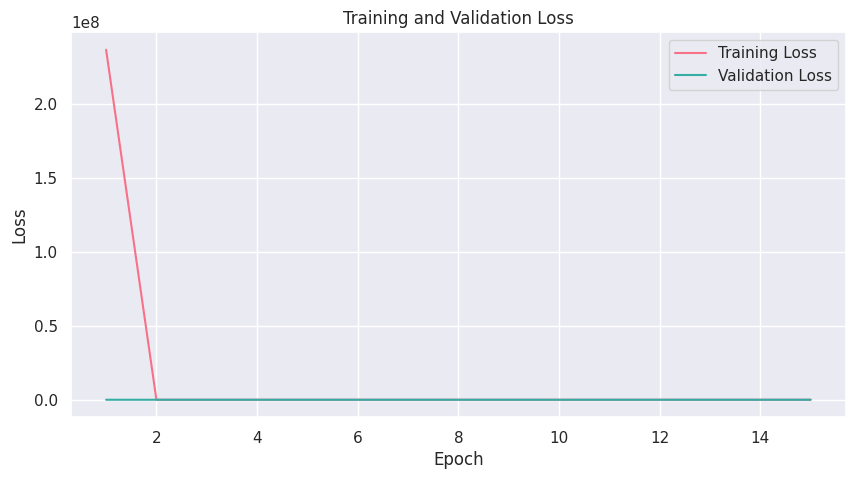

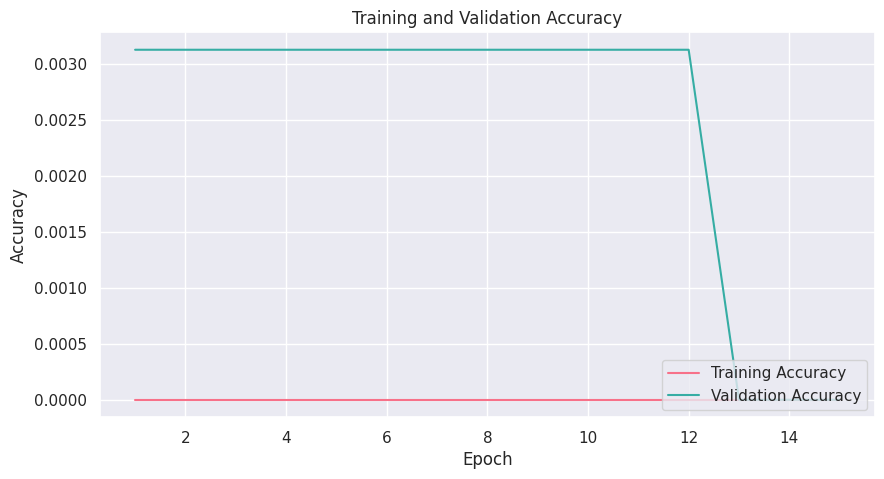

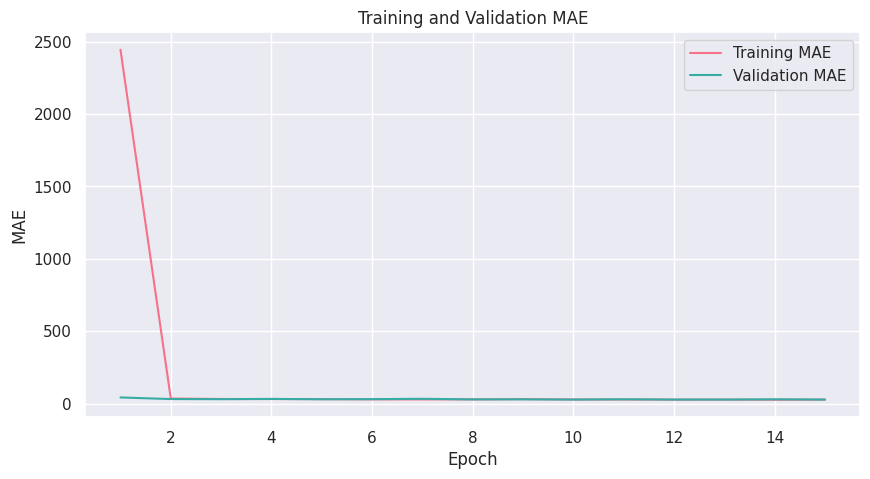

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Obtener las métricas de entrenamiento y validación del historial
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Crear un DataFrame para Seaborn
epochs = range(1, len(train_loss) + 1)
history_df = pd.DataFrame({'Epoch': epochs,
                           'Training Loss': train_loss,
                           'Validation Loss': val_loss,
                           'Training Accuracy': train_acc,
                           'Validation Accuracy': val_acc,
                           'Training MAE': train_mae,
                           'Validation MAE': val_mae})

# Graficar las pérdidas
sns.set(style="darkgrid")
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training Loss', 'Validation Loss']),
             palette="husl")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Graficar la precisión
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training Accuracy', 'Validation Accuracy']),
             palette="husl")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Graficar el MAE
plt.figure(figsize=(10, 5))
sns.lineplot(x='Epoch', y='value', hue='variable',
             data=pd.melt(history_df, id_vars=['Epoch'], value_vars=['Training MAE', 'Validation MAE']),
             palette="husl")
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.show()


### For 6 NN with 224,224

In [16]:

def separar_imagen(imagen):
    """
    Separa una imagen con dimensiones (224, 224, 6) en 6 imágenes con dimensiones (224, 224, 1).

    Args:
    imagen (numpy.ndarray): Imagen original con dimensiones (224, 224, 6).

    Returns:
    tuple: Una tupla con 6 numpy.ndarrays, cada uno con dimensiones (224, 224, 1).
    """
    # Verificar que la imagen tenga las dimensiones correctas
    assert imagen.shape == (224, 224, 6), "La imagen debe tener dimensiones (224, 224, 6)"
    
    # Separar la imagen en 6 partes
    imagenes_separadas = tuple(imagen[:, :, i][:, :, np.newaxis] for i in range(6))
    
    return imagenes_separadas

In [17]:
def data_generator_layer(image_files, lista,layer):
    i=0
    for file in image_files:
        mp10=tf.convert_to_tensor(lista[i],dtype=tf.float32)
        image = preprocess_imagery(file)
        image= separar_imagen(image)[layer]
        image=tf.convert_to_tensor(image, dtype=tf.float32)
        yield image, mp10

# Crear el Dataset
def create_dataset_layer(image_files,lista,layer, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator_layer,
        args=[image_files, lista,layer],
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    dataset = dataset.batch(batch_size)
    return dataset

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout

def build_model_layer():
    # Crear el modelo secuencial
    model = Sequential()

    # Añadir la capa de convolución 2D
    model.add(Conv2D(filters=4, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))

    # Añadir la capa de Average Pooling
    model.add(AveragePooling2D(pool_size=(2, 2)))
    # Segunda capa de convolución 2D
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Tercera capa de convolución 2D
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Cuarta capa de convolución 2D
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Aplanar la salida de la capa de pooling
    model.add(Flatten())

    # Añadir una capa densa
    model.add(Dense(units=64, activation='relu'))

    # Añadir la capa de Dropout
    model.add(Dropout(rate=0.5))

    # Añadir la capa de salida con activación lineal
    model.add(Dense(units=1, activation='linear'))
    return model

#### Model for layer 0

In [19]:
model_0=build_model_layer()
# Compilar el modelo
adam=tf.keras.optimizers.Adam(learning_rate=0.0005)
model_0.compile(optimizer=adam, loss='mean_squared_error' ,metrics=['mae'])

# Resumen del modelo
model_0.summary()

c:\Users\benja\anaconda3\envs\ee\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 4)    │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_16            │ (None, 111, 111, 4)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_17            │ (None, 54, 54, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_18            │ (None, 26, 26, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_19            │ (None, 12, 12, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,665 (600.25 KB)

 Trainable params: 153,665 (600.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Configuración de entrenamiento
batch_size = 500
epochs = 5
full_history_0=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    dataset = create_dataset_layer(image_files_part, mp10_part,0, batch_size)
    history=model_0.fit(dataset,epochs=epochs,batch_size=50)
    full_history_0.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    dataset = create_dataset_layer(image_files_part, mp10_part,0, batch_size)
    history=model_0.fit(dataset,epochs=epochs,batch_size=50)
    full_history_0.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


C:\Users\benja\AppData\Local\Temp\ipykernel_11140\3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 206s 206s/step - loss: 48990.2109 - mae: 118.5184
Epoch 2/5


c:\Users\benja\anaconda3\envs\ee\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 202s 202s/step - loss: 1390248.5000 - mae: 654.0399
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 203s 203s/step - loss: 173761.2188 - mae: 232.9966
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 202s 202s/step - loss: 15217.4668 - mae: 81.8060
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 201s 201s/step - loss: 33467.8945 - mae: 91.0144
Part:  2
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 195s 195s/step - loss: 27882.6855 - mae: 102.6592
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 193s 193s/step - loss: 15206.6885 - mae: 86.9483
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 193s 193s/step - loss: 14052.4443 - mae: 85.1959
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 192s 192s/step - loss: 8674.1641 - mae: 74.4953
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 194s 194s/step - loss: 8112.8027 - mae: 71.2760
Part:  3
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 197s 197s/step - loss: 5419.3281 - mae: 52.9052
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 195s 195s/step - loss: 3980.9358 - mae: 49.7372
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 195s 195s/step - loss: 2425.757

In [13]:
dataset = create_dataset_layer(test_image_files, test_mp10,0, batch_size)
op_0=model_0.evaluate(dataset)

/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 243s 120s/step - loss: 384.4989 - mae: 17.5384


2024-05-29 01:51:24.612612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 1

In [14]:
model_1=build_model_layer()
# Compilar el modelo
model_1.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

# Resumen del modelo
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 12, 12, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,106,689 (19.48 MB)

 Trainable params: 5,106,689 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Configuración de entrenamiento
batch_size = 500
epochs = 5
full_history_1=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    dataset = create_dataset_layer(image_files_part, mp10_part,1, batch_size)
    history=model_1.fit(dataset,epochs=epochs,batch_size=50)
    full_history_1.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    dataset = create_dataset_layer(image_files_part, mp10_part,1, batch_size)
    history=model_1.fit(dataset,epochs=epochs,batch_size=50)
    full_history_1.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 99988.8828 - mae: 182.6839
Epoch 2/5


2024-05-29 01:53:25.109624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 697771840.0000 - mae: 18392.2637
Epoch 3/5


2024-05-29 01:55:25.326502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 1103886.0000 - mae: 617.5804
Epoch 4/5


2024-05-29 01:57:25.311690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 4154636.7500 - mae: 1308.3850
Epoch 5/5


2024-05-29 01:59:25.226614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 794507.6875 - mae: 551.8484
Part:  2
Epoch 1/5


2024-05-29 02:01:24.573096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 185225.6406 - mae: 260.6009
Epoch 2/5


2024-05-29 02:03:24.111361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 306457.5000 - mae: 341.0396
Epoch 3/5


2024-05-29 02:05:24.398604: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 323121.9375 - mae: 328.5974
Epoch 4/5


2024-05-29 02:07:25.756937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 89649.6719 - mae: 195.0177
Epoch 5/5


2024-05-29 02:09:26.272068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 56104.3516 - mae: 155.3864
Part:  3
Epoch 1/5


2024-05-29 02:11:26.418146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 47871.0156 - mae: 125.9539
Epoch 2/5


2024-05-29 02:13:28.509101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 12014.5234 - mae: 76.2811
Epoch 3/5


2024-05-29 02:15:31.398221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 8723.3486 - mae: 71.2061
Epoch 4/5


2024-05-29 02:17:34.379445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 1185.2360 - mae: 31.8757
Epoch 5/5


2024-05-29 02:19:36.763150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 1524.3323 - mae: 32.7135
Part:  4
Epoch 1/5


2024-05-29 02:21:38.689007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 797.7089 - mae: 25.7644
Epoch 2/5


2024-05-29 02:23:39.571290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 754.0282 - mae: 25.6480
Epoch 3/5


2024-05-29 02:25:41.440241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 786.2645 - mae: 26.9670
Epoch 4/5


2024-05-29 02:27:43.040061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 733.0361 - mae: 24.9433
Epoch 5/5


2024-05-29 02:29:45.569973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 768.5330 - mae: 24.1405
Part:  5
Epoch 1/5


2024-05-29 02:31:46.915978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 728.4179 - mae: 23.0976
Epoch 2/5


2024-05-29 02:33:48.797097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 1405.9423 - mae: 34.3822
Epoch 3/5


2024-05-29 02:35:50.967653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 6803.8604 - mae: 55.5967
Epoch 4/5


2024-05-29 02:37:52.204645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 907.6743 - mae: 29.6035
Epoch 5/5


2024-05-29 02:39:52.934864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 925.1578 - mae: 30.4084
Part:  6
Epoch 1/5


2024-05-29 02:41:55.355207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1905.5342 - mae: 41.8526
Epoch 2/5


2024-05-29 02:43:53.135637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 11091.8936 - mae: 75.3693
Epoch 3/5


2024-05-29 02:45:50.563086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2309.6658 - mae: 48.0259
Epoch 4/5


2024-05-29 02:47:48.857426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1806.9169 - mae: 41.1954
Epoch 5/5


2024-05-29 02:49:46.135373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 25669.3340 - mae: 110.5667
Part:  7
Epoch 1/5


2024-05-29 02:51:43.063535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 3726.1890 - mae: 59.9373
Epoch 2/5


2024-05-29 02:53:42.602094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 3630.2385 - mae: 59.6671
Epoch 3/5


2024-05-29 02:55:42.659395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 2984.5088 - mae: 54.6279
Epoch 4/5


2024-05-29 02:57:42.297799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 2953.2173 - mae: 54.3416
Epoch 5/5


2024-05-29 02:59:42.237067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 2941.9441 - mae: 54.2357
Part:  8
Epoch 1/5


2024-05-29 03:01:41.934779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2392.4065 - mae: 48.9020
Epoch 2/5


2024-05-29 03:03:39.664862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1886.2850 - mae: 42.5312
Epoch 3/5


2024-05-29 03:05:38.131340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 103889.2031 - mae: 220.5164
Epoch 4/5


2024-05-29 03:07:36.088026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2327.4316 - mae: 48.1858
Epoch 5/5


2024-05-29 03:09:34.981443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1951.1488 - mae: 43.4214


2024-05-29 03:11:32.175308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [16]:
dataset = create_dataset_layer(test_image_files, test_mp10,1, batch_size)
op=model_1.evaluate(dataset)

/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 230s 114s/step - loss: 2751.3127 - mae: 42.8880


2024-05-29 03:15:21.892644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 2

In [17]:
model_2=build_model_layer()
# Compilar el modelo
model_2.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

# Resumen del modelo
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_8             │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 12, 12, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,106,689 (19.48 MB)

 Trainable params: 5,106,689 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Configuración de entrenamiento
batch_size = 500
epochs = 5
full_history_2=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    dataset = create_dataset_layer(image_files_part, mp10_part,2, batch_size)
    history=model_2.fit(dataset,epochs=epochs,batch_size=50)
    full_history_2.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    dataset = create_dataset_layer(image_files_part, mp10_part,2, batch_size)
    history=model_2.fit(dataset,epochs=epochs,batch_size=50)
    full_history_2.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 237480.8438 - mae: 283.3502
Epoch 2/5


2024-05-29 03:17:22.942647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 527883840.0000 - mae: 15628.7842
Epoch 3/5


2024-05-29 03:19:23.309711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 17014136.0000 - mae: 2514.2314
Epoch 4/5


2024-05-29 03:21:22.676395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 8506516.0000 - mae: 1865.0215
Epoch 5/5


2024-05-29 03:23:22.722340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1442368.0000 - mae: 745.4696
Part:  2
Epoch 1/5


2024-05-29 03:25:23.368860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 257176.0000 - mae: 278.1941
Epoch 2/5


2024-05-29 03:27:23.597825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 30491.0742 - mae: 123.5408
Epoch 3/5


2024-05-29 03:29:23.112101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 23381.2988 - mae: 111.3703
Epoch 4/5


2024-05-29 03:31:23.364069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 70574.7031 - mae: 170.7435
Epoch 5/5


2024-05-29 03:33:22.570809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 62592.0938 - mae: 187.6841
Part:  3
Epoch 1/5


2024-05-29 03:35:22.477527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 6157.2720 - mae: 62.6747
Epoch 2/5


2024-05-29 03:37:24.672414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 3399.0505 - mae: 44.2279
Epoch 3/5


2024-05-29 03:39:26.815517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 16413.3105 - mae: 89.3233
Epoch 4/5


2024-05-29 03:41:28.843588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 4992.2070 - mae: 50.5838
Epoch 5/5


2024-05-29 03:43:29.743608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 1807.2249 - mae: 37.0060
Part:  4
Epoch 1/5


2024-05-29 03:45:31.875000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 1845.1189 - mae: 35.4703
Epoch 2/5


2024-05-29 03:47:32.169665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 2084.2432 - mae: 39.3971
Epoch 3/5


2024-05-29 03:49:33.248803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 1208.7397 - mae: 30.2053
Epoch 4/5


2024-05-29 03:51:35.986932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1524.6040 - mae: 31.0230
Epoch 5/5


2024-05-29 03:53:36.766185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1016.0955 - mae: 28.0228
Part:  5
Epoch 1/5


2024-05-29 03:55:37.280826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 646.0670 - mae: 22.8442
Epoch 2/5


2024-05-29 03:57:38.205393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 612.4713 - mae: 22.7177
Epoch 3/5


2024-05-29 03:59:38.193306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 604.3286 - mae: 22.7117
Epoch 4/5


2024-05-29 04:01:37.324960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 602.6717 - mae: 22.8314
Epoch 5/5


2024-05-29 04:03:37.931598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 654.1086 - mae: 21.6395
Part:  6
Epoch 1/5


2024-05-29 04:05:38.771397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1855.1929 - mae: 42.0870
Epoch 2/5


2024-05-29 04:07:36.617668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1788.8744 - mae: 41.1204
Epoch 3/5


2024-05-29 04:09:33.711496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1546.5145 - mae: 36.4700
Epoch 4/5


2024-05-29 04:11:30.420643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 116s 116s/step - loss: 1475.9642 - mae: 33.9188
Epoch 5/5


2024-05-29 04:13:26.750685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1659.5406 - mae: 34.6487
Part:  7
Epoch 1/5


2024-05-29 04:15:23.437305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1760.4280 - mae: 36.9599
Epoch 2/5


2024-05-29 04:17:21.925524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 1800.5699 - mae: 36.8802
Epoch 3/5


2024-05-29 04:19:21.103898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 1919.0477 - mae: 41.8392
Epoch 4/5


2024-05-29 04:21:21.205040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 1760.5464 - mae: 39.1306
Epoch 5/5


2024-05-29 04:23:21.368907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2688.6316 - mae: 40.7598
Part:  8
Epoch 1/5


2024-05-29 04:25:20.297598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1549.2230 - mae: 37.7593
Epoch 2/5


2024-05-29 04:27:18.574677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2142.4897 - mae: 41.1792
Epoch 3/5


2024-05-29 04:29:17.717013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1930.8645 - mae: 43.5016
Epoch 4/5


2024-05-29 04:31:15.288771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1874.6594 - mae: 42.7737
Epoch 5/5


2024-05-29 04:33:13.111885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1740.3053 - mae: 40.7989


2024-05-29 04:35:10.041693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [19]:
dataset = create_dataset_layer(test_image_files, test_mp10,2, batch_size)
op_2=model_2.evaluate(dataset)

/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 231s 116s/step - loss: 346.0310 - mae: 17.0707


2024-05-29 04:39:01.464083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 3

In [20]:
model_3=build_model_layer()
# Compilar el modelo
model_3.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

# Resumen del modelo
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_14            │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_15            │ (None, 12, 12, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,106,689 (19.48 MB)

 Trainable params: 5,106,689 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Configuración de entrenamiento
batch_size = 500
epochs = 5
full_history_3=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    dataset = create_dataset_layer(image_files_part, mp10_part,3, batch_size)
    history=model_3.fit(dataset,epochs=epochs,batch_size=50)
    full_history_3.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    dataset = create_dataset_layer(image_files_part, mp10_part,3, batch_size)
    history=model_3.fit(dataset,epochs=epochs,batch_size=50)
    full_history_3.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 232350.0156 - mae: 294.0926
Epoch 2/5


2024-05-29 04:41:02.821381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 749077504.0000 - mae: 19427.0059
Epoch 3/5


2024-05-29 04:43:05.038997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 768351.0000 - mae: 511.5494
Epoch 4/5


2024-05-29 04:45:03.984456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 4851544.5000 - mae: 1500.4989
Epoch 5/5


2024-05-29 04:47:04.373374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1875051.6250 - mae: 929.2424
Part:  2
Epoch 1/5


2024-05-29 04:49:05.187970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 405536.1250 - mae: 432.9389
Epoch 2/5


2024-05-29 04:51:04.901644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 8885.0713 - mae: 74.7717
Epoch 3/5


2024-05-29 04:53:04.981295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 73150.2969 - mae: 171.9378
Epoch 4/5


2024-05-29 04:55:04.889032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 45560.5898 - mae: 161.9841
Epoch 5/5


2024-05-29 04:57:06.241078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 28424.4004 - mae: 130.0718
Part:  3
Epoch 1/5


2024-05-29 04:59:06.501499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 10689.6289 - mae: 80.3154
Epoch 2/5


2024-05-29 05:01:09.327843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 2424.8469 - mae: 45.9461
Epoch 3/5


2024-05-29 05:03:11.931395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 2009.6790 - mae: 43.1635
Epoch 4/5


2024-05-29 05:05:14.268785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1452.6508 - mae: 37.9501
Epoch 5/5


2024-05-29 05:07:14.981352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1295.6466 - mae: 35.9951
Part:  4
Epoch 1/5


2024-05-29 05:09:16.187951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1661.1986 - mae: 34.6743
Epoch 2/5


2024-05-29 05:11:14.187815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 14183.1748 - mae: 93.7128
Epoch 3/5


2024-05-29 05:13:15.135469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 1057.5742 - mae: 30.4827
Epoch 4/5


2024-05-29 05:15:14.322517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 31685.3594 - mae: 117.3835
Epoch 5/5


2024-05-29 05:17:14.179580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 86283.8125 - mae: 181.3049
Part:  5
Epoch 1/5


2024-05-29 05:19:14.625882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 909.2415 - mae: 30.1536
Epoch 2/5


2024-05-29 05:21:15.931536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 909.2304 - mae: 30.1535
Epoch 3/5


2024-05-29 05:23:16.550071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 909.2281 - mae: 30.1534
Epoch 4/5


2024-05-29 05:25:16.343303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 909.1206 - mae: 30.1516
Epoch 5/5


2024-05-29 05:27:17.415620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 909.0314 - mae: 30.1501
Part:  6
Epoch 1/5


2024-05-29 05:29:17.576012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2399.7134 - mae: 48.9869
Epoch 2/5


2024-05-29 05:31:16.298829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2399.2827 - mae: 48.9825
Epoch 3/5


2024-05-29 05:33:14.122467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 2397.8054 - mae: 48.9673
Epoch 4/5


2024-05-29 05:35:11.453109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 2050.7422 - mae: 44.4420
Epoch 5/5


2024-05-29 05:37:08.499943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 20536.9199 - mae: 100.2569
Part:  7
Epoch 1/5


2024-05-29 05:39:05.275625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 2317.7275 - mae: 44.6231
Epoch 2/5


2024-05-29 05:41:06.421166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 2952.7583 - mae: 54.3374
Epoch 3/5


2024-05-29 05:43:06.242464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 10633.9619 - mae: 82.8534
Epoch 4/5


2024-05-29 05:45:05.815393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2928.9998 - mae: 54.1069
Epoch 5/5


2024-05-29 05:47:05.010382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 6765.5786 - mae: 69.7928
Part:  8
Epoch 1/5


2024-05-29 05:49:04.598508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2344.0664 - mae: 48.3723
Epoch 2/5


2024-05-29 05:51:02.634135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1618.6626 - mae: 36.5703
Epoch 3/5


2024-05-29 05:53:01.121366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 67118.3281 - mae: 172.8390
Epoch 4/5


2024-05-29 05:54:58.836170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2181.0923 - mae: 46.3474
Epoch 5/5


2024-05-29 05:56:57.072273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 2100.4019 - mae: 45.1478


2024-05-29 05:58:54.028929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [22]:
dataset = create_dataset_layer(test_image_files, test_mp10,3, batch_size)
op_3=model_3.evaluate(dataset)

/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 230s 114s/step - loss: 443.3064 - mae: 18.7633


2024-05-29 06:02:43.855114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 4

In [23]:
model_4=build_model_layer()
# Compilar el modelo
model_4.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

# Resumen del modelo
model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_16            │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_17            │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_18            │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_19            │ (None, 12, 12, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,106,689 (19.48 MB)

 Trainable params: 5,106,689 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Configuración de entrenamiento
batch_size = 500
epochs = 5
full_history_4=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    dataset = create_dataset_layer(image_files_part, mp10_part,4, batch_size)
    history=model_4.fit(dataset,epochs=epochs,batch_size=50)
    full_history_4.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    dataset = create_dataset_layer(image_files_part, mp10_part,4, batch_size)
    history=model_4.fit(dataset,epochs=epochs,batch_size=50)
    full_history_4.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1700717.8750 - mae: 899.4903
Epoch 2/5


2024-05-29 06:04:44.825423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 764555520.0000 - mae: 19722.6797
Epoch 3/5


2024-05-29 06:06:44.715085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 10745577.0000 - mae: 2351.8171
Epoch 4/5


2024-05-29 06:08:45.192115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 310599.6250 - mae: 362.1993
Epoch 5/5


2024-05-29 06:10:46.028774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 82389.5859 - mae: 174.3141
Part:  2
Epoch 1/5


2024-05-29 06:12:47.073770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 69399.1016 - mae: 177.1761
Epoch 2/5


2024-05-29 06:14:48.761562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 27273.9199 - mae: 116.4131
Epoch 3/5


2024-05-29 06:16:49.297948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 32179.2695 - mae: 135.0041
Epoch 4/5


2024-05-29 06:18:50.393124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 3655089.5000 - mae: 1333.6593
Epoch 5/5


2024-05-29 06:20:48.612261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 50311.5859 - mae: 170.3412
Part:  3
Epoch 1/5


2024-05-29 06:22:49.598107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 120207.2031 - mae: 252.8681
Epoch 2/5


2024-05-29 06:24:52.411851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 127537.7500 - mae: 251.1742
Epoch 3/5


2024-05-29 06:26:54.779096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 90574.9531 - mae: 214.6026
Epoch 4/5


2024-05-29 06:28:56.766170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 37065.9844 - mae: 138.3523
Epoch 5/5


2024-05-29 06:30:59.955228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 6423.6396 - mae: 64.6755
Part:  4
Epoch 1/5


2024-05-29 06:33:00.588378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 1064.3246 - mae: 32.6239
Epoch 2/5


2024-05-29 06:35:03.091395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 2604.3228 - mae: 43.7110
Epoch 3/5


2024-05-29 06:37:04.341081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1064.3302 - mae: 32.6239
Epoch 4/5


2024-05-29 06:39:05.499435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1064.6207 - mae: 32.6285
Epoch 5/5


2024-05-29 06:41:06.558133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1064.6354 - mae: 32.6288
Part:  5
Epoch 1/5


2024-05-29 06:43:07.483888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 909.7324 - mae: 30.1618
Epoch 2/5


2024-05-29 06:45:09.498000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 909.7276 - mae: 30.1617
Epoch 3/5


2024-05-29 06:47:07.600967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 909.7003 - mae: 30.1612
Epoch 4/5


2024-05-29 06:49:07.969271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 909.5986 - mae: 30.1596
Epoch 5/5


2024-05-29 06:51:09.219506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 909.3043 - mae: 30.1547
Part:  6
Epoch 1/5


2024-05-29 06:53:10.195589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 2399.5349 - mae: 48.9850
Epoch 2/5


2024-05-29 06:55:07.156808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 139142.8594 - mae: 228.7783
Epoch 3/5


2024-05-29 06:57:05.053280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 2399.6670 - mae: 48.9864
Epoch 4/5


2024-05-29 06:59:02.549865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 2400.7861 - mae: 48.9978
Epoch 5/5


2024-05-29 07:00:59.288080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 2400.8767 - mae: 48.9987
Part:  7
Epoch 1/5


2024-05-29 07:02:56.256156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2976.4290 - mae: 54.5566
Epoch 2/5


2024-05-29 07:04:55.430627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 2976.0200 - mae: 54.5529
Epoch 3/5


2024-05-29 07:06:55.226968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2975.9329 - mae: 54.5520
Epoch 4/5


2024-05-29 07:08:54.484033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2975.8115 - mae: 54.5509
Epoch 5/5


2024-05-29 07:10:52.278653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 2975.2354 - mae: 54.5455
Part:  8
Epoch 1/5


2024-05-29 07:12:52.170891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2440.9646 - mae: 49.4058
Epoch 2/5


2024-05-29 07:14:49.729657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2439.9414 - mae: 49.3950
Epoch 3/5


2024-05-29 07:16:48.683673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2438.9395 - mae: 49.3846
Epoch 4/5


2024-05-29 07:18:47.555420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2436.6870 - mae: 49.3610
Epoch 5/5


2024-05-29 07:20:46.009110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 2433.0000 - mae: 49.3215


2024-05-29 07:22:43.131688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [25]:
dataset = create_dataset_layer(test_image_files, test_mp10,4, batch_size)
op_4=model_4.evaluate(dataset)

/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 231s 115s/step - loss: 810.7557 - mae: 28.4640


2024-05-29 07:26:33.858992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


#### Model for layer 5

In [26]:
model_5=build_model_layer()
# Compilar el modelo
model_5.compile(optimizer='adam', loss='mean_squared_error' ,metrics=['mae'])

# Resumen del modelo
model_5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_20            │ (None, 111, 111, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_21            │ (None, 54, 54, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_22            │ (None, 26, 26, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_23            │ (None, 12, 12, 256)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,106,689 (19.48 MB)

 Trainable params: 5,106,689 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Configuración de entrenamiento
batch_size = 500
epochs = 5
full_history_5=[]
# Dividir el conjunto de datos en partes (si es necesario)
num_parts = len(train_image_files) // batch_size
for part in range(num_parts):
    print("Part: ",part+1)
    part_history = {'loss': [], 'mae': []}
    start = part * batch_size
    end=(part+1)* batch_size
    image_files_part = train_image_files[start:end]
    mp10_part = mp10[start:end]
    dataset = create_dataset_layer(image_files_part, mp10_part,5, batch_size)
    history=model_5.fit(dataset,epochs=epochs,batch_size=50)
    full_history_5.append([history.history['loss'],history.history['mae']])
if len(image_files) % batch_size != 0:
    image_files_part = train_image_files[num_parts * batch_size:]
    mp10_part = mp10[num_parts * batch_size:]
    dataset = create_dataset_layer(image_files_part, mp10_part,5, batch_size)
    history=model_5.fit(dataset,epochs=epochs,batch_size=50)
    full_history_5.append([history.history['loss'],history.history['mae']])

Part:  1
Epoch 1/5


/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 55796.9844 - mae: 154.0094
Epoch 2/5


2024-05-29 07:28:35.375732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 111446152.0000 - mae: 7469.3071
Epoch 3/5


2024-05-29 07:30:36.278320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 3907741.2500 - mae: 1344.1577
Epoch 4/5


2024-05-29 07:32:37.055054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1599515.1250 - mae: 907.0801
Epoch 5/5


2024-05-29 07:34:35.109290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 220703.8438 - mae: 332.3592
Part:  2
Epoch 1/5


2024-05-29 07:36:35.550893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 795767.0000 - mae: 649.7995
Epoch 2/5


2024-05-29 07:38:37.599990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 24339.7949 - mae: 113.4410
Epoch 3/5


2024-05-29 07:40:38.017600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 133193.4062 - mae: 262.4509
Epoch 4/5


2024-05-29 07:42:38.454826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 71297.0625 - mae: 193.5507
Epoch 5/5


2024-05-29 07:44:39.535654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 12868.6182 - mae: 86.1652
Part:  3
Epoch 1/5


2024-05-29 07:46:40.669143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 12696.6963 - mae: 83.8354
Epoch 2/5


2024-05-29 07:48:41.930055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 27466.1523 - mae: 115.5129
Epoch 3/5


2024-05-29 07:50:44.258445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 14658.1582 - mae: 88.8450
Epoch 4/5


2024-05-29 07:52:46.724533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 8728.4805 - mae: 69.1616
Epoch 5/5


2024-05-29 07:54:49.308643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 123s 123s/step - loss: 5857.0669 - mae: 58.6369
Part:  4
Epoch 1/5


2024-05-29 07:56:52.643275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 3429.6768 - mae: 45.9395
Epoch 2/5


2024-05-29 07:58:53.875739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2774.5422 - mae: 43.4780
Epoch 3/5


2024-05-29 08:00:53.208896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 3526.6565 - mae: 49.5548
Epoch 4/5


2024-05-29 08:02:54.376248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 2378.4465 - mae: 41.5482
Epoch 5/5


2024-05-29 08:04:55.636207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 122s 122s/step - loss: 1307.4414 - mae: 31.5349
Part:  5
Epoch 1/5


2024-05-29 08:06:57.337688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 2735.1992 - mae: 41.3747
Epoch 2/5


2024-05-29 08:08:58.693192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 841.6307 - mae: 25.6806
Epoch 3/5


2024-05-29 08:10:59.367125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 1880.6249 - mae: 35.4794
Epoch 4/5


2024-05-29 08:12:59.943739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 860.1498 - mae: 26.5378
Epoch 5/5


2024-05-29 08:15:00.303866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 121s 121s/step - loss: 661.9553 - mae: 22.6995
Part:  6
Epoch 1/5


2024-05-29 08:17:01.156107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1902.9354 - mae: 41.9230
Epoch 2/5


2024-05-29 08:18:58.277983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1393.3395 - mae: 33.6113
Epoch 3/5


2024-05-29 08:20:56.242439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 4184.3706 - mae: 52.6153
Epoch 4/5


2024-05-29 08:22:53.313718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1617.0695 - mae: 38.1774
Epoch 5/5


2024-05-29 08:24:50.337108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1510.2417 - mae: 36.5539
Part:  7
Epoch 1/5


2024-05-29 08:26:47.161160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 2508.6221 - mae: 47.0697
Epoch 2/5


2024-05-29 08:28:47.352443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 1595.0031 - mae: 36.7195
Epoch 3/5


2024-05-29 08:30:47.101856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 6162.6455 - mae: 62.5439
Epoch 4/5


2024-05-29 08:32:45.965095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 2563.1489 - mae: 49.7792
Epoch 5/5


2024-05-29 08:34:45.402833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 120s 120s/step - loss: 2543.5535 - mae: 48.9481
Part:  8
Epoch 1/5


2024-05-29 08:36:44.914503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 117s 117s/step - loss: 1434.6395 - mae: 34.3876
Epoch 2/5


2024-05-29 08:38:42.386190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 2906.7786 - mae: 40.8043
Epoch 3/5


2024-05-29 08:40:40.349168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1285.9512 - mae: 30.7759
Epoch 4/5


2024-05-29 08:42:38.163486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 119s 119s/step - loss: 1621.9202 - mae: 37.2553
Epoch 5/5


2024-05-29 08:44:37.548148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 118s 118s/step - loss: 1454.5850 - mae: 34.7414


2024-05-29 08:46:35.523698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [28]:
dataset = create_dataset_layer(test_image_files, test_mp10,5, batch_size)
op_5=model_5.evaluate(dataset)

/tmp/ipykernel_4433/3210126769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image=imageio.imread(path)
/tmp/ipykernel_4433/3210126769.py:13: RuntimeWarning: Mean of empty slice
  mean=np.nanmean(image,axis=(0,1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 230s 114s/step - loss: 386.0600 - mae: 15.4035


2024-05-29 08:50:25.602833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [30]:
op_5

[389.5055236816406, 15.501727104187012]

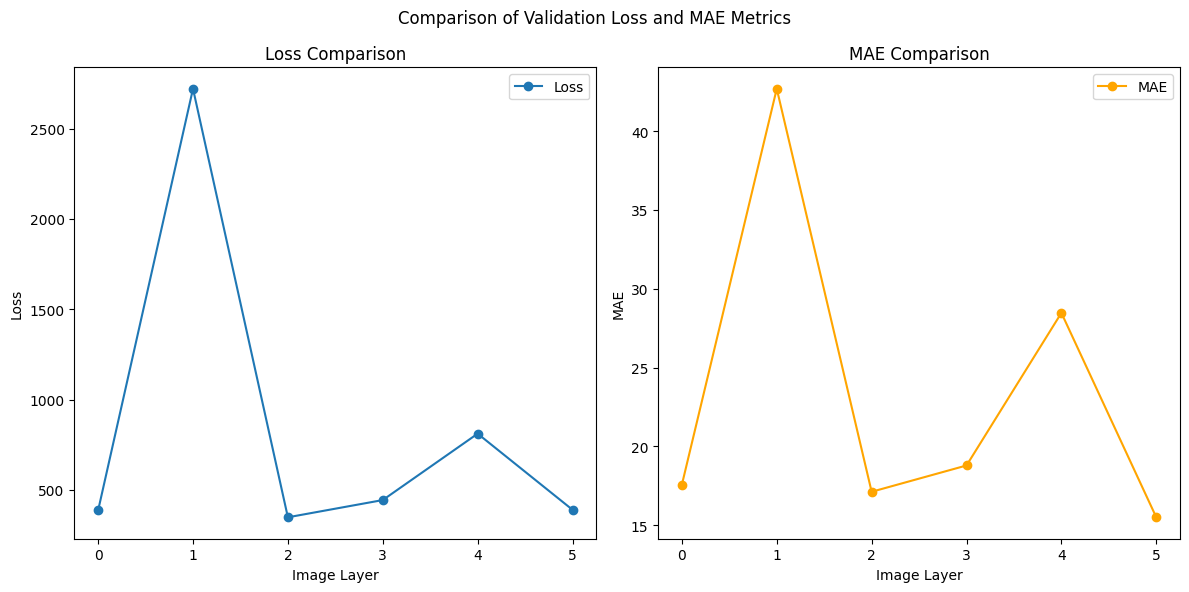

In [36]:
import matplotlib.pyplot as plt

# Assuming you have op_0 to op_5 arrays with loss and MAE values
# Replace these with your actual data

# Extract loss and MAE values
loss_values = [op[0] for op in [op_0, op, op_2, op_3, op_4, op_5]]
mae_values = [op[1] for op in [op_0, op, op_2, op_3, op_4, op_5]]

# Create subplots for loss and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss
ax1.plot(loss_values, marker='o', label='Loss')
ax1.set_title('Loss Comparison')
ax1.set_xlabel('Image Layer')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot MAE
ax2.plot(mae_values, marker='o', color='orange', label='MAE')
ax2.set_title('MAE Comparison')
ax2.set_xlabel('Image Layer')
ax2.set_ylabel('MAE')
ax2.legend()
plt.suptitle('Comparison of Validation Loss and MAE Metrics')
plt.tight_layout()
plt.show()
